# **Machinery Diagnostic Assistant: Enhancing Predictive Maintenance with GenAI**

# Problem Statement

Industrial machinery failures can lead to costly downtime and safety risks. While sensors can detect potential issues, interpreting this data requires expertise that isn't always available.

This project demonstrates how we can combine machine learning classification with Generative AI to create an automated system that not only detects equipment faults but provides clear explanations and recommendations to maintenance teams.

By enhancing traditional fault diagnosis with GenAI capabilities, a solution is proposed that bridges the technical gap between sensor data and practical maintenance decisions.

# Solution

A diagnostic assistant is built that:

1. Uses a machine learning classifier to categorize common rotating equipment faults from vibration time series data
2. Employs GenAI to interpret these results and provide human-readable insights
3. Generates structured maintenance recommendations

The project showcases three key GenAI capabilities:

* Function calling: Connecting our classifier with the LLM
* Structured output: Creating consistent diagnostic reports in JSON format
* Few-shot prompting: Providing examples to guide the LLM's responses

## Disclaimer

This implementation is for demonstration purposes only. The vibration data is simulated and does not represent real-world measurements. The fault patterns, classifier, and GenAI interpretations are simplified examples to showcase the integration of these technologies. In a production environment, you would need properly calibrated sensors, validated fault signatures, and domain expertise to create reliable diagnostic systems.

Let's set up our environment first:

In [1]:
# Install required libraries
!pip install -q numpy scikit-learn matplotlib
!pip install -U -q "google-genai==1.7.0"

# Import necessary modules
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import json
from IPython.display import display, Markdown
import random

# Configure the Gemini API
import os
from google import genai
from google.genai import types
from kaggle_secrets import UserSecretsClient

# Get API key from Kaggle secrets
GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
client = genai.Client(api_key=GOOGLE_API_KEY)

genai.__version__

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 4.2 MB/s eta 0:00:00


'1.7.0'

# Step 1: Creating Synthetic Vibration Data

In real-world scenarios, vibration data would come from sensors attached to machinery. For this demonstration, we'll generate synthetic data representing different fault conditions:

In [2]:
def generate_vibration_data(fault_type, samples=1000, sample_rate=1000):
    """Generate synthetic vibration signals for different fault conditions."""
    t = np.arange(samples) / sample_rate  # Time vector
    rotation_freq = 25  # Hz - base rotation frequency
    
    # Base signal (common to all conditions)
    signal = 0.5 * np.sin(2 * np.pi * rotation_freq * t)
    
    # Add fault-specific components
    if fault_type == 'normal':
        # Just small random noise
        noise = np.random.normal(0, 0.1, samples)
        signal = signal + noise
        
    elif fault_type == 'imbalance':
        # Increased amplitude at rotation frequency
        imbalance = 2.0 * np.sin(2 * np.pi * rotation_freq * t)
        noise = np.random.normal(0, 0.15, samples)
        signal = signal + imbalance + noise
        
    elif fault_type == 'misalignment':
        # Spikes at 2x and 3x rotation frequency
        misalign_2x = 1.2 * np.sin(2 * np.pi * 2 * rotation_freq * t)
        misalign_3x = 0.8 * np.sin(2 * np.pi * 3 * rotation_freq * t)
        noise = np.random.normal(0, 0.2, samples)
        signal = signal + misalign_2x + misalign_3x + noise
        
    elif fault_type == 'bearing_fault':
        # Base characteristic frequency for bearing fault
        bpfo = 85  # Hz (Bearing Pass Frequency Outer race)
        
        # Create base signal with characteristic frequency and harmonics
        bearing_signal = np.zeros(samples)
        # Fundamental frequency
        bearing_signal += 1.4 * np.sin(2 * np.pi * bpfo * t)
        # Add harmonics (2x, 3x, 4x the base frequency)
        bearing_signal += 1.2 * np.sin(2 * np.pi * 2 * bpfo * t)
        bearing_signal += 1.0 * np.sin(2 * np.pi * 3 * bpfo * t)
        bearing_signal += 0.7 * np.sin(2 * np.pi * 4 * bpfo * t)
        
        noise = np.random.normal(0, 0.25, samples)
        signal = signal + bearing_signal + noise
    
    return t, signal

def extract_signal_features(time, signal):
    """Extract meaningful features from vibration signals."""
    # Time domain features
    rms = np.sqrt(np.mean(signal**2))
    peak = np.max(np.abs(signal))
    crest_factor = peak / rms if rms > 0 else 0
    
    # Frequency domain features (via FFT)
    signal_fft = np.abs(np.fft.rfft(signal))
    freqs = np.fft.rfftfreq(len(signal), d=time[1]-time[0])
    
    # Extract dominant frequencies
    sorted_indices = np.argsort(signal_fft)[-3:]  # Top 3 frequencies
    dom_freqs = freqs[sorted_indices]
    dom_amps = signal_fft[sorted_indices]
    
    return {
        "rms_amplitude": rms,
        "peak_amplitude": peak,
        "crest_factor": crest_factor,
        "dominant_freq_1": dom_freqs[-1] if len(dom_freqs) > 0 else 0,
        "dominant_freq_2": dom_freqs[-2] if len(dom_freqs) > 1 else 0,
        "dominant_freq_3": dom_freqs[-3] if len(dom_freqs) > 2 else 0,
        "amplitude_ratio_1": dom_amps[-1]/np.sum(signal_fft) if np.sum(signal_fft) > 0 else 0,
        "amplitude_ratio_2": dom_amps[-2]/np.sum(signal_fft) if np.sum(signal_fft) > 0 else 0
    }

def build_dataset(samples_per_fault=50):
    """Create a dataset with multiple samples of each fault type."""
    fault_types = ['normal', 'imbalance', 'misalignment', 'bearing_fault']
    features_list = []
    labels = []
    
    for fault in fault_types:
        for _ in range(samples_per_fault):
            # Add some variation to each sample
            sample_count = np.random.randint(950, 1050)
            rate = np.random.randint(950, 1050)
            
            time, signal = generate_vibration_data(fault, sample_count, rate)
            features = extract_signal_features(time, signal)
            
            features_list.append(list(features.values()))
            labels.append(fault)
    
    # Convert to numpy arrays
    X = np.array(features_list)
    y = np.array(labels)
    feature_names = list(features.keys())
    
    return X, y, feature_names

Let's visualize our synthetic data to understand the fault patterns:

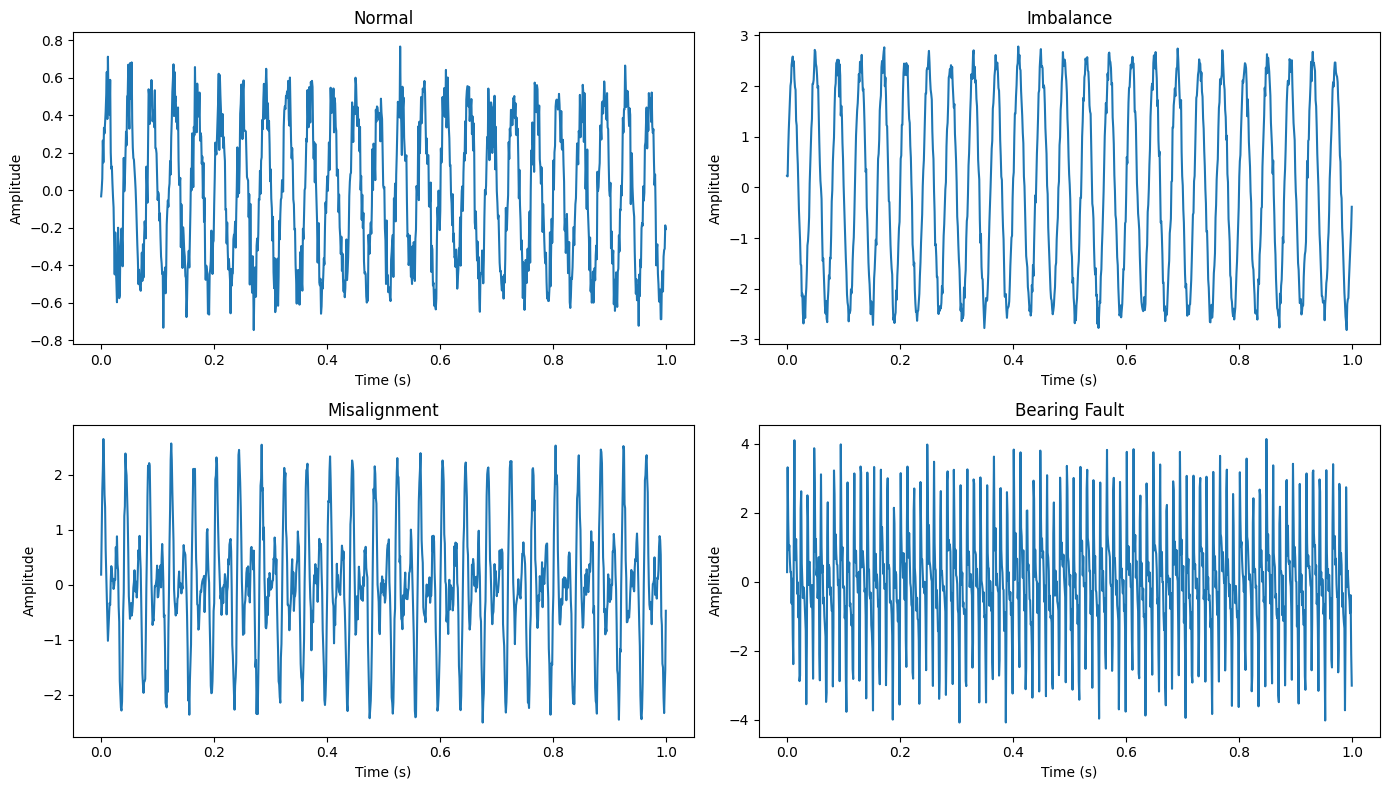

Dataset created with 240 samples and 8 features
Features: ['rms_amplitude', 'peak_amplitude', 'crest_factor', 'dominant_freq_1', 'dominant_freq_2', 'dominant_freq_3', 'amplitude_ratio_1', 'amplitude_ratio_2']


In [3]:
# Visualize examples of each fault type
plt.figure(figsize=(14, 8))
fault_types = ['normal', 'imbalance', 'misalignment', 'bearing_fault']

for i, fault in enumerate(fault_types):
    plt.subplot(2, 2, i+1)
    t, signal = generate_vibration_data(fault)
    plt.plot(t, signal)
    plt.title(f"{fault.replace('_', ' ').title()}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

# Create dataset for training
X, y, feature_names = build_dataset(samples_per_fault=60)
print(f"Dataset created with {len(X)} samples and {len(feature_names)} features")
print(f"Features: {feature_names}")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Training a Fault Classifier

Now we'll train a Support Vector Machine (SVM) classifier to identify different fault types based on the vibration features:

In [4]:
# Create and train the SVM model
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = svm_classifier.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classifier accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Create a function to classify new vibration data
def classify_fault(time_series, vibration_signal):
    """
    Classify the type of fault from vibration data.
    
    Args:
        time_series: Time array
        vibration_signal: Vibration amplitude array
    
    Returns:
        Dictionary with classification results and probabilities
    """
    # Extract features from the signal
    features = extract_signal_features(time_series, vibration_signal)
    
    # Scale features
    feature_array = np.array(list(features.values())).reshape(1, -1)
    scaled_features = scaler.transform(feature_array)
    
    # Get prediction and probabilities
    fault_type = svm_classifier.predict(scaled_features)[0]
    probabilities = svm_classifier.predict_proba(scaled_features)[0]
    
    # Create dictionary of fault probabilities
    fault_probs = {}
    for i, fault in enumerate(svm_classifier.classes_):
        fault_probs[fault] = float(probabilities[i])
    
    # Return comprehensive result
    return {
        "detected_fault": fault_type,
        "confidence": float(max(probabilities)),
        "fault_probabilities": fault_probs,
        "signal_features": features
    }

Classifier accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

bearing_fault       1.00      1.00      1.00        19
    imbalance       1.00      1.00      1.00        14
 misalignment       1.00      1.00      1.00        14
       normal       1.00      1.00      1.00        13

     accuracy                           1.00        60
    macro avg       1.00      1.00      1.00        60
 weighted avg       1.00      1.00      1.00        60



# Step 3: Integrating GenAI for Fault Interpretation

Now, let's set up Gemini to interpret the classifier results with a focus on providing actionable insights:

In [5]:
# Define the system prompt for our assistant
system_prompt = """You are an expert in machinery diagnostics specializing in rotating equipment. 
Your role is to interpret vibration analysis results and provide clear maintenance advice.

When analyzing fault classifications, you should:
1. Explain what the detected fault is in simple terms
2. List the most common causes for this type of fault
3. Describe what could happen if the fault is not addressed
4. Provide specific maintenance recommendations
5. Indicate how urgently the issue should be addressed

Your response must be formatted as a JSON object with these fields:
- fault_explanation: A clear explanation of what this fault is
- probable_causes: Array of potential causes
- potential_consequences: What might happen if not addressed
- maintenance_actions: Array of recommended actions
- priority_level: One of [Critical, High, Medium, Low]
- recommended_timeframe: When this should be addressed (e.g., "Within 24 hours")
"""

# Create few-shot examples to guide the model
examples = [
    {
        "classifier_output": {
            "detected_fault": "imbalance",
            "confidence": 0.89,
            "fault_probabilities": {
                "normal": 0.05,
                "imbalance": 0.89,
                "misalignment": 0.04,
                "bearing_fault": 0.02
            }
        },
        "response": {
            "fault_explanation": "Imbalance occurs when the center of mass of a rotating component doesn't align with its center of rotation, causing vibration that increases with speed.",
            "probable_causes": [
                "Uneven material buildup on rotors or fan blades",
                "Missing counterweights",
                "Manufacturing defects",
                "Uneven wear of rotating components"
            ],
            "potential_consequences": "Continued operation with imbalance can lead to increased bearing wear, reduced equipment efficiency, and eventual catastrophic failure. The vibration can also damage nearby components.",
            "maintenance_actions": [
                "Perform dynamic balancing of the rotor",
                "Clean any buildup on rotating components",
                "Inspect for and replace any damaged or worn parts",
                "Check mounting and base for proper support"
            ],
            "priority_level": "Medium",
            "recommended_timeframe": "Within 2 weeks"
        }
    },
    {
        "classifier_output": {
            "detected_fault": "bearing_fault",
            "confidence": 0.95,
            "fault_probabilities": {
                "normal": 0.01,
                "imbalance": 0.02,
                "misalignment": 0.02,
                "bearing_fault": 0.95
            }
        },
        "response": {
            "fault_explanation": "A bearing fault indicates damage to one or more components of a rolling element bearing (inner race, outer race, cage, or rolling elements themselves).",
            "probable_causes": [
                "Inadequate lubrication",
                "Contamination in the bearing",
                "Excessive loading",
                "Improper installation",
                "Electric current passage through bearing"
            ],
            "potential_consequences": "Bearing faults rapidly deteriorate and can lead to complete bearing seizure, causing severe damage to shafts and housings, potential fires, and catastrophic equipment failure with minimal warning.",
            "maintenance_actions": [
                "Replace the affected bearing immediately",
                "Check and improve lubrication practices",
                "Inspect shaft and housing for damage",
                "Verify proper alignment after replacement",
                "Consider root cause analysis to prevent recurrence"
            ],
            "priority_level": "Critical",
            "recommended_timeframe": "Within 24-48 hours"
        }
    }
]

# Function to get interpretation from Gemini
def get_fault_interpretation(classification_result):
    """
    Use Gemini to interpret fault classification results and provide recommendations.
    
    Args:
        classification_result: Dictionary with classifier output
        
    Returns:
        Dictionary with fault interpretation and maintenance recommendations
    """
    # Create the prompt with system instruction and few-shot examples
    prompt = f"""You are an expert in machinery diagnostics specializing in rotating equipment. 
Your role is to interpret vibration analysis results and provide clear maintenance advice.

Analyze this vibration-based fault classification result and provide expert interpretation:
    
{json.dumps(classification_result, indent=2)}

Your response must be formatted as a JSON object with these fields:
- fault_explanation: A clear explanation of what this fault is
- probable_causes: Array of potential causes
- potential_consequences: What might happen if not addressed
- maintenance_actions: Array of recommended actions
- priority_level: One of [Critical, High, Medium, Low]
- recommended_timeframe: When this should be addressed (e.g., "Within 24 hours")

Here are examples of how to interpret similar results:

Example 1:
{json.dumps(examples[0], indent=2)}

Example 2:
{json.dumps(examples[1], indent=2)}

Your interpretation:
"""
    
    # Generate the response with structured output
    response = client.models.generate_content(
        model="gemini-2.0-flash-exp",
        contents=prompt,
        config=types.GenerateContentConfig(
            temperature=0.2,
            response_mime_type="application/json"
        )
    )

    
    # Parse the JSON response
    try:
        interpretation = json.loads(response.text)
        return interpretation
    except json.JSONDecodeError:
        return {"error": "Failed to parse response", "raw_text": response.text}

# Step 4: Demonstrating the Complete System

Let's create a function to demonstrate our fault diagnosis assistant in action:

## 🔍 Demonstrating fault diagnosis for: Misalignment

### ⚙️ Step 1: Running vibration analysis classifier...

Classifier detected: **Misalignment** (Confidence: 0.91)

Raw classifier output:

```json
{
  "detected_fault": "misalignment",
  "confidence": 0.9069287825398857,
  "fault_probabilities": {
    "bearing_fault": 0.020799197203435746,
    "imbalance": 0.03261006916484132,
    "misalignment": 0.9069287825398857,
    "normal": 0.039661951091836886
  },
  "signal_features": {
    "rms_amplitude": 1.108639947651098,
    "peak_amplitude": 2.7568999858117484,
    "crest_factor": 2.4867406155198166,
    "dominant_freq_1": 50.0,
    "dominant_freq_2": 75.0,
    "dominant_freq_3": 25.0,
    "amplitude_ratio_1": 0.15173015416613445,
    "amplitude_ratio_2": 0.10164223566131027
  }
}
```

### 🧠 Step 2: Generating AI interpretation and recommendations...

## 📋 Expert Diagnosis and Recommendations:

### Fault Diagnosis: Misalignment

**Explanation**: Misalignment occurs when the centerlines of two connected rotating components (e.g., a motor and a pump) are not coaxial. This induces forces and moments that cause increased vibration, especially at harmonics of the running speed.

**Probable Causes**:
- Thermal expansion causing shifts in alignment
- Foundation settling or distortion
- Improper installation or maintenance procedures
- Worn or damaged couplings
- Loosened mounting bolts

**Potential Consequences**: Misalignment can lead to premature bearing failure, coupling damage, increased energy consumption, shaft fatigue, and reduced equipment lifespan. The vibration can also loosen other components.

**Recommended Actions**:
- Perform precision laser alignment of the coupled equipment
- Inspect couplings for wear and damage; replace if necessary
- Check and tighten all mounting bolts
- Verify base flatness and rigidity
- Consider using flexible couplings to accommodate minor misalignments

**Priority**: High

**Timeframe**: Within 1 week


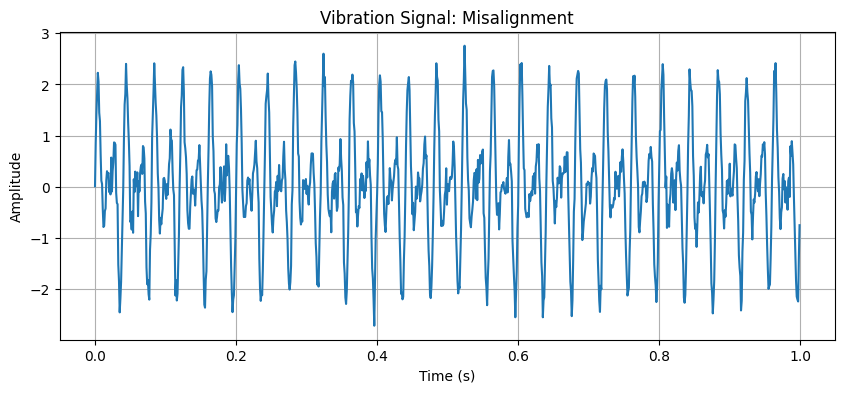

In [6]:
def demonstrate_fault_diagnosis(fault_type=None):
    """
    Demonstrate the full fault diagnosis workflow with a sample case.
    
    Args:
        fault_type: Optional specific fault to demonstrate, otherwise random
    """
    # Choose a random fault type if none specified
    fault_types = ['normal', 'imbalance', 'misalignment', 'bearing_fault']
    if fault_type is None:
        fault_type = random.choice(fault_types)
    
    # Start building the markdown output
    md_output = f"## 🔍 Demonstrating fault diagnosis for: {fault_type.replace('_', ' ').title()}\n\n"
    
    # Generate sample vibration data
    time, signal = generate_vibration_data(fault_type)
    
    # Step 1: Run the classifier
    md_output += "### ⚙️ Step 1: Running vibration analysis classifier...\n\n"
    result = classify_fault(time, signal)
    
    # Display classifier output
    md_output += f"Classifier detected: **{result['detected_fault'].replace('_', ' ').title()}** (Confidence: {result['confidence']:.2f})\n\n"
    md_output += "Raw classifier output:\n\n"
    md_output += f"```json\n{json.dumps(result, indent=2)}\n```\n\n"
    
    # Step 2: Get GenAI interpretation
    md_output += "### 🧠 Step 2: Generating AI interpretation and recommendations...\n\n"
    interpretation = get_fault_interpretation(result)
    
    # Display the interpretation
    md_output += "## 📋 Expert Diagnosis and Recommendations:\n\n"
    md_output += f"### Fault Diagnosis: {result['detected_fault'].replace('_', ' ').title()}\n\n"
    md_output += f"**Explanation**: {interpretation['fault_explanation']}\n\n"
    md_output += "**Probable Causes**:\n"
    
    for cause in interpretation['probable_causes']:
        md_output += f"- {cause}\n"

    md_output += f"\n**Potential Consequences**: {interpretation['potential_consequences']}\n\n"
    md_output += "**Recommended Actions**:\n"

    for action in interpretation['maintenance_actions']:
        md_output += f"- {action}\n"

    md_output += f"\n**Priority**: {interpretation['priority_level']}\n\n"
    md_output += f"**Timeframe**: {interpretation['recommended_timeframe']}\n"

    display(Markdown(md_output))
    
    # Show vibration signal
    plt.figure(figsize=(10, 4))
    plt.plot(time, signal)
    plt.title(f"Vibration Signal: {fault_type.replace('_', ' ').title()}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()
    
    return result, interpretation

# Run the demonstration
demo_result, demo_interpretation = demonstrate_fault_diagnosis()

# Step 5: Function Calling from GenAI

Let's demonstrate the function calling capability by allowing the LLM to decide when to analyze vibration data:

In [7]:
# Define a function for Gemini to call
def analyze_equipment_vibration(equipment_id, measurement_location):
    """
    Analyze vibration data from a specific piece of equipment.
    
    Args:
        equipment_id: Identifier for the equipment being analyzed
        measurement_location: Where the measurement was taken (e.g., "drive end bearing")
        
    Returns:
        Analysis results including fault diagnosis and recommendations
    """
    # In a real system, we would fetch actual data for this equipment
    # For demo purposes, we'll generate synthetic data
    
    # Randomly select a fault type based on equipment ID (for consistent demos)
    fault_types = ['normal', 'imbalance', 'misalignment', 'bearing_fault']
    random.seed(hash(equipment_id) % 100)  # Use equipment ID as seed
    fault_type = random.choice(fault_types)
    
    # Generate vibration data
    time, signal = generate_vibration_data(fault_type)
    
    # Run the classifier
    classification = classify_fault(time, signal)
    
    # Get interpretation
    interpretation = get_fault_interpretation(classification)
    
    # Return combined results
    return {
        "equipment_id": equipment_id,
        "measurement_location": measurement_location,
        "classification_result": classification,
        "expert_interpretation": interpretation,
        "actual_fault_type": fault_type  # This would not be in a real system, just for demo
    }

# Define functions for Gemini to use
tools = [
    {
        "function_declarations": [
            {
                "name": "analyze_equipment_vibration",
                "description": "Analyze vibration data from rotating equipment to detect faults",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "equipment_id": {
                            "type": "string",
                            "description": "Identifier for the equipment to analyze"
                        },
                        "measurement_location": {
                            "type": "string",
                            "description": "Location where vibration was measured (e.g., 'drive end bearing')"
                        }
                    },
                    "required": ["equipment_id", "measurement_location"]
                }
            }
        ]
    }
]

# Function to handle function calling
def call_function(function_name, function_args):
    """Call the appropriate function based on function name and args."""
    if function_name == "analyze_equipment_vibration":
        return analyze_equipment_vibration(**function_args)
    else:
        return {"error": f"Unknown function: {function_name}"}

# Create a chat function demonstrating function calling
def chat_with_diagnostic_assistant(query):
    """
    Chat with the diagnostic assistant, demonstrating function calling.
    
    Args:
        query: User question or request
    """
    print(f"User: {query}")
    
    model_with_tools = client.chats.create(
        model="gemini-2.0-flash-exp",
        config=types.GenerateContentConfig(
            tools=tools,
        ),
    )
    
    # Create a prompt that includes the instructions that would have been in the system role
    prompt = """You are a helpful assistant specializing in rotating equipment diagnostics. 
When users ask about equipment condition or mention vibration problems, analyze the data 
by calling the analyze_equipment_vibration function.

User query: """ + query
    
    # Generate response
    response = model_with_tools.send_message(prompt)
    
    # Check if the model called a function
    function_calls = []
    if hasattr(response, 'candidates') and response.candidates:
        for part in response.candidates[0].content.parts:
            if hasattr(part, 'function_call') and part.function_call:
                function_calls.append(part.function_call)
    
    # If there are function calls, execute them and provide results back to the model
    if function_calls:
        function_responses = []
        for call in function_calls:
            function_name = call.name
            # Convert MapComposite args to a regular Python dictionary
            function_args = {}
            for key, value in call.args.items():
                function_args[key] = value
            
            print(f"\n🔧 Assistant is calling function: {function_name}")
            print(f"With arguments: {json.dumps(function_args, indent=2)}")
            
            # Call the function
            function_result = call_function(function_name, function_args)
            
            function_responses.append({
                "name": function_name,
                "response": {"result": function_result}
            })
        
        # Get the final response
        follow_up_prompt = f"""You are a helpful assistant specializing in rotating equipment diagnostics. 
Provide a concise summary of the analysis results.

The user asked: {query}

You called a function to analyze the equipment with these parameters: {json.dumps(function_args, indent=2)}
The function returned the following analysis results:
{json.dumps(function_responses[0]["response"]["result"], indent=2)}
Your response:"""
        response = model_with_tools.send_message(follow_up_prompt)
    
    # Display the assistant's response
    print("\nAssistant:")
    display(Markdown(response.text))
    
    return response

# Demonstrate function calling
_ = chat_with_diagnostic_assistant("Can you check the condition of pump P-101? We've noticed increased vibration on the drive end bearing.")

User: Can you check the condition of pump P-101? We've noticed increased vibration on the drive end bearing.

🔧 Assistant is calling function: analyze_equipment_vibration
With arguments: {
  "equipment_id": "P-101",
  "measurement_location": "drive end bearing"
}

Assistant:


The analysis indicates a high probability of misalignment in pump P-101 at the drive end bearing. Maintenance actions, including laser alignment, should be performed within one week to avoid potential damage.


# Conclusion

In this project, it was demonstrated how Generative AI can enhance traditional fault diagnosis systems by adding context, expertise, and actionable insights to raw classification results. The proposed approach combines three powerful GenAI capabilities:

1. Function Calling: The LLM is enabled to trigger vibration analysis when appropriate during conversation, creating a more natural diagnostic experience.
2. Few-Shot Prompting: By providing examples of expert interpretations, the LLM is guided to generate consistent and relevant responses even with limited domain knowledge.
3. Structured Output: The diagnostic information was delivered in a consistent JSON format, making it easy to integrate into existing maintenance systems.

This approach bridges the technical gap between sensor data and practical maintenance actions, helping teams make informed decisions without specialized vibration analysis expertise. While this demonstration used synthetic data, the same principles apply to real-world vibration monitoring systems.
By combining traditional machine learning with GenAI, I've created a more accessible and useful predictive maintenance solution that could help reduce downtime, extend equipment life, and improve maintenance efficiency in industrial settings.

# 🙏 Acknowledgments

Huge thanks to:

* **Google** and **Kaggle** for organizing the **Gen AI Intensive Course**, which inspired this project.
* The course instructors who shared their expertise in generative AI applications.


## 📝 Related Publication

This project has been documented in detail in my Medium article:
[Machinery Diagnostic Assistant: Enhancing Predictive Maintenance with GenAI](https://medium.com/@ali.dibaj93/machinery-diagnostic-assistant-enhancing-predictive-maintenance-with-genai-547ca9eddf8a)

Feel free to check it out for additional context, implementation details, and insights about this project!